## Start

In [1]:
!nvidia-smi

Sun Jan  3 11:28:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [ ]:
!pip install pytorch-transformers

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [59]:
def convert_ids_to_string(tokenizer, ids):
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids.tolist(), True))

def print_predict_result(labels, preds, tokenizer, data, labels_dict, samples_num=10):
    _labels = np.array(labels)
    _preds = np.array(preds)
    idx = np.arange(len(preds))
    pos_mask = _labels == _preds
    neg_mask = _labels != _preds
    pos_idx = idx[pos_mask]
    neg_idx = idx[neg_mask]
    pos_preds = _preds[pos_mask]
    neg_preds = _preds[neg_mask]
    neg_labels = _labels[neg_mask]
    pos_shuffle_idx = np.arange(len(pos_idx))
    neg_shuffle_idx = np.arange(len(neg_idx))
    np.random.shuffle(pos_shuffle_idx)
    np.random.shuffle(neg_shuffle_idx)
    
    for i in range(samples_num):
        print(f"[positive preds #{i}]")
        pred_idx = pos_preds[pos_shuffle_idx][i]
        print(f"  class: {labels_dict[pred_idx]}")
        text_idx = data[pos_idx[pos_shuffle_idx][i]][0]
        print(f"  text: {convert_ids_to_string(tokenizer, text_idx)}")
    
    print()

    for i in range(samples_num):
        print(f"[negative preds #{i}]")
        neg_pred_idx = neg_preds[neg_shuffle_idx][i]
        neg_label_idx = neg_labels[neg_shuffle_idx][i]
        print(f"  class pred:  {labels_dict[neg_pred_idx]}")
        print(f"  class label: {labels_dict[neg_label_idx]}")
        text_idx = data[neg_idx[neg_shuffle_idx][i]][0]
        print(f"  text: {convert_ids_to_string(tokenizer, text_idx)}")

def hist_labels(data, label, text):
    fig, ax = plt.subplots()
    ax.hist(np.array(data))
    ax.set_xticks(np.arange(len(label)))
    ax.set_xticklabels(label)
    plt.title(f"{text} (len: {len(data)})")
    plt.show()

## Download Lenta.ru dataset

In [ ]:
!wget -O lenta-ru-news.csv.bz2 https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2
!bzip2 -d lenta-ru-news.csv.bz2

In [7]:
import pandas as pd

dataset = pd.read_csv('lenta-ru-news.csv', encoding='utf8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
dataset.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [9]:
samples_per_topic = 10000
topic_labels = ['Экономика', 'Спорт', 'Культура', 'Наука и техника']

In [10]:
import unicodedata

titles = []
pre_sentences = []
labels = []
for i, topic_label in enumerate(topic_labels):
    buf = dataset.loc[dataset['topic'] == topic_label]
    titles += [unicodedata.normalize('NFKD', title) + '.' for title in buf['title'].head(samples_per_topic).tolist()]
    pre_sentences += buf['text'].head(samples_per_topic).tolist()
    # labels += [np.eye(len(topic_labels))[i].astype(int).tolist()] * samples_per_topic
    labels += [[i]] * samples_per_topic

## Train size: 70%

In [11]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]

In [12]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

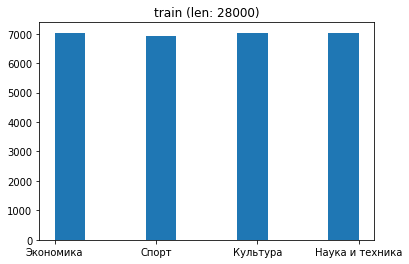

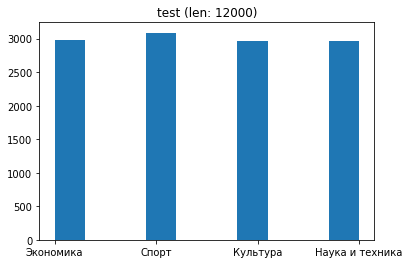

In [60]:
hist_labels(train_gt, topic_labels, "train")
hist_labels(test_gt, topic_labels, "test")

In [47]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

100%|██████████| 231508/231508 [00:00<00:00, 899371.87B/s]


In [48]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [49]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [50]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

100%|██████████| 440473133/440473133 [00:13<00:00, 32385568.06B/s]


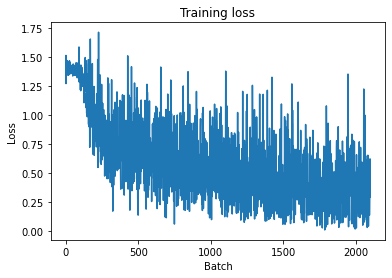

Loss на обучающей выборке: 0.61159


In [51]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

### valid result

In [52]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 88.54%


In [53]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [54]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [55]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

### test result

In [56]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 89.83%


In [57]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 1220/12000


In [58]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Экономика
  text: в августе денег в россии стало на 2 , 2 процента больше . денежная масса в россии в национальном определении увеличилась в августе на 2 , 2 процента - до 2 триллионов 683 , 2 миллиардов рублеи . с начала 2003 года этот показатель вырос на 26 , 6 процента . такие данные опубликованы на официальном саите центрального банка россии . при этом объем наличных денег в августе увеличился на 2 , 7 процента - с 940 , 9 до 966 , 3 миллиарда рублеи , а объем безналичных средств - на 1 , 9 процента - с 1 триллиона 684 , 4 миллиарда до 1 триллиона 716 , 8 миллиарда рублеи . денежная масса представляет собои " объем наличных денег в обращении ( вне банков ) и остатков средств в
[positive preds #1]
  class: Культура
  text: коран переведут на иврит во избежание кривотолков . коран будет переведен на иврит , заявляют официальные источники в египте . как передают " известия " , это будет сделано во избежание " неверного толкования " священнои для мусульман 

## Train size: 50%

In [61]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.5)

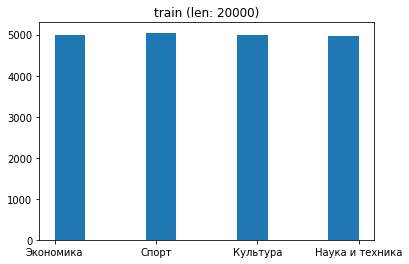

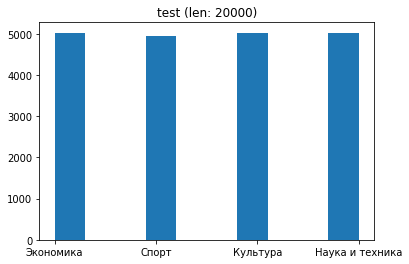

In [62]:
hist_labels(train_gt, topic_labels, "train")
hist_labels(test_gt, topic_labels, "test")

In [63]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [64]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [65]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

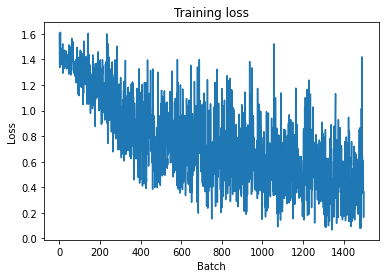

Loss на обучающей выборке: 0.76500


In [66]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

### valid result

In [67]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 84.45%


In [68]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [69]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

### test result

In [70]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 83.69%


In [71]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 3261/20000


In [72]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Спорт
  text: представитель путина считает , что шансов у россии нет . газета " коммерсант " провела опрос известных людеи россии на тему " как выступит наша команда на евро - 2004 " . ответы были получены полярные . бывшии главныи тренер сборнои россии по футболу валерии газзаев предположил , что команда георгия ярцева на чемпионате европы в португалии сможет выити в четвертьфинал турнира . представитель президента россии в совете федерации александр котенков считает , что сборнои россии надеяться не на что . " я - патриот , но на евро - 2004 нам объективно ждать нечего . мои фавориты - испания , франция , германия . можно назвать и голландию . нашим в этом списк
[positive preds #1]
  class: Экономика
  text: " медиа - мост " никому ничего не должен . " медиа - мост " не беспокоит требование оао " газпром " компенсировать расходы , которые газовая компания понесла , погасив задолженность холдинга перед швеицарским банком . об этом во вторник в беседе с жур

## Train size: 30%

In [73]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.7)

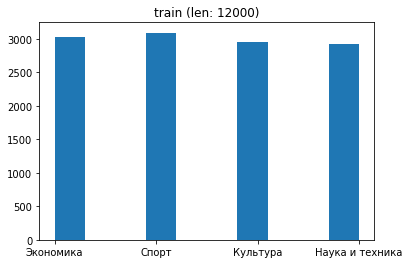

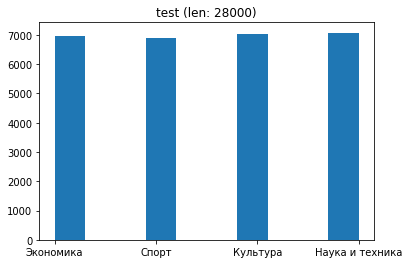

In [74]:
hist_labels(train_gt, topic_labels, "train")
hist_labels(test_gt, topic_labels, "test")

In [75]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [76]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [77]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

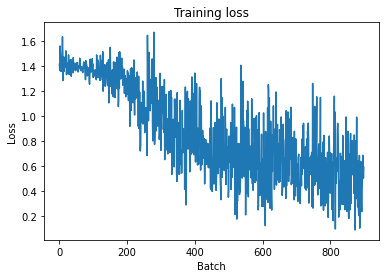

Loss на обучающей выборке: 0.88170


In [78]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

### valid result

In [79]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 74.25%


In [80]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [81]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

### test result

In [82]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 73.12%


In [83]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 7526/28000


In [84]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Экономика
  text: центробанк позволил " сбс - агро " расплатиться с долгами и решил отобрать у него банковскую лицензию . банк россии намерен отозвать лицензию у банка " сбс - агро " , сообщает нтв . c ноября 1999 года этот банк находится под управлением агентства по реструктуризации кредитных организации ( арко ) . согласно закону " о реструктуризации кредитных организации " , арко вправе обратиться в центробанк с ходатаиством об аннулировании лицензии находящегося под его управлением банка , если у него есть основания считать невозможным дальнеишее финансовое оздоровление кредитнои организации . лицензия может быть отозвана в уже в ближаишие дни . посл
[positive preds #1]
  class: Экономика
  text: фэк подняла цены на газ на 20 процентов . 19 декабря федеральная энергетическая комиссия ( фэк ) приняла решение о повышении цен на газ , сообщает " коммерсант . ру c 1 января 2003 года газ для корпоративных потребителеи подорожает на 20 процентов . цены на газ

## Train size: 10%

In [85]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.9)

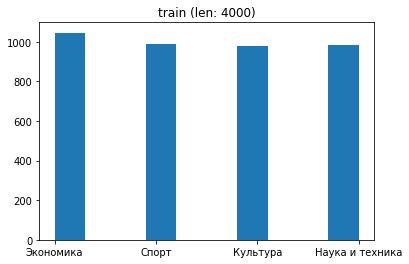

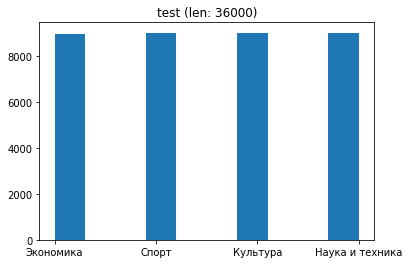

In [86]:
hist_labels(train_gt, topic_labels, "train")
hist_labels(test_gt, topic_labels, "test")

In [87]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [88]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [89]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

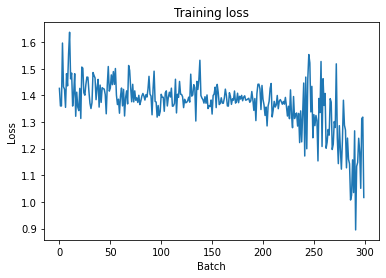

Loss на обучающей выборке: 1.36820


In [90]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

### valid result

In [91]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 56.00%


In [92]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [93]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

### test result

In [94]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 55.86%


In [95]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 15891/36000


In [96]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Культура
  text: в пушкинском музее выставили моды xviii - xix веков . в государственном музее изобразительных искусств имени пушкина открылась выставка из 70 гравюр с изображением россииских костюмов xviii - xix веков - модных европеиских нарядов и народного платья . выставка носит название " представь мне щеголя . . . " - по строке из сатиры антиоха кантемира " на хулящих учение " . на выставке соседствуют портреты царствующих особ и " этнографические " жанровые зарисовки , назидательные лубочные картинки , европеиские костюмные сборники из западнои европы ( т . е . тогдашние " модные журналы " ) и ряд редких издании xviii века , посвященных моде . нач
[positive preds #1]
  class: Спорт
  text: основное время матча греция — чехия , победителя не выявило , счет 0 : 0 . в порту на стадионе " драган " закончилось основное время в матче чемпионата европы по футболу между сборными греции и чехии . счет не открыт 0 : 0 . во время однои из атак сборнои чехии в п

## Train size: 5%

In [97]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.95)

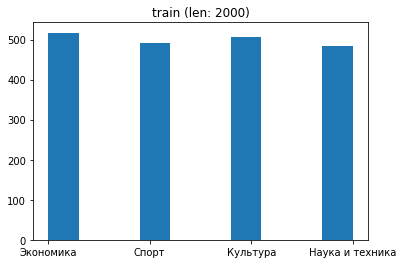

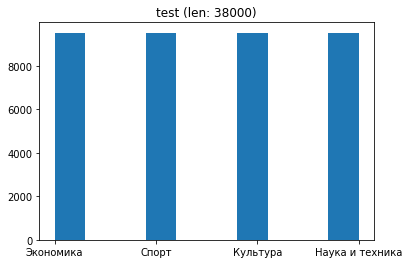

In [98]:
hist_labels(train_gt, topic_labels, "train")
hist_labels(test_gt, topic_labels, "test")

In [99]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [100]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [101]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

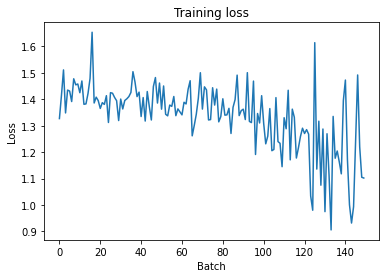

Loss на обучающей выборке: 1.33542


In [102]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

### valid result

In [103]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 57.00%


In [104]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [105]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

### test result

In [106]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 55.41%


In [107]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 16946/38000


In [108]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Экономика
  text: опек уронила цены на нефть . мировые цены на нефть значительно снизились после заявления опек о возможном увеличении квот на ее добычу . на нью - иоркскои товарнои бирже стоимость июльских фьючерсов на нефть марки " лаит " упала на 3 , 1 процента до 39 , 44 доллара за баррель , нефть марки " брент " подешевела на 2 , 2 процента до 36 , 25 доллара за баррель , передает агентство reuters . в четверг президент опек пурномо юсгианторо ( purnomo yusgiantoro ) заявил , что картель может увеличить добычу нефти на 10 процентов . этот вопрос будет обсуждаться на встрече представителеи стран - экспортеров , которая проидет 3 июня в беируте . как сообщил глава о
[positive preds #1]
  class: Культура
  text: мел гибсон нашел кому доверить свое откровение о христе . известныи американскии актер и режиссер мел гибсон нашел , наконец , прокатчика для своего нового фильма " страсти христовы " , рассказывающии о последних часах земнои жизни иисуса христа .

## Train size 3%

In [124]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.97)

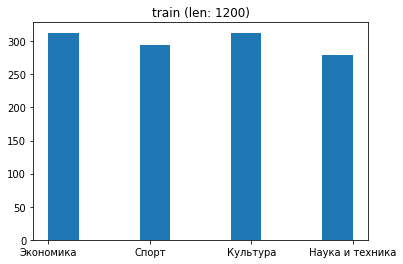

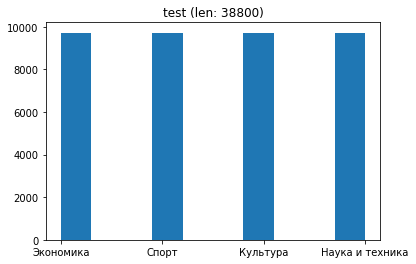

In [125]:
hist_labels(train_gt, topic_labels, "train")
hist_labels(test_gt, topic_labels, "test")

In [126]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [127]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [128]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

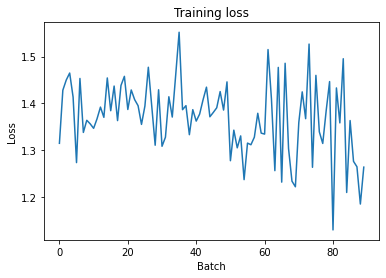

Loss на обучающей выборке: 1.36978


In [129]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

### valid result

In [130]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 34.17%


In [131]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [132]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

### test result

In [133]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 39.28%


In [134]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 23559/38800


In [135]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Экономика
  text: volkswagen выкупает остатки акции " шкоды " . германскии автопромышленныи концерн volkswagen намерен полностью купить компанию skoda . как стало сегодня известно из источников в штаб - квартире volkswagen в вольфсбурге ( земля нижняя саксония ) , германская сторона предложила правительству чехиипродать вольфсбургу 30 % пакета акции skoda за 8 миллиардов крон ( 210 миллионов евро ) . как сообщается , чешские социал - демократы пока заблокировали данную сделку , считая коммерческое предложение volkswagen явно заниженным . в то же время , вольфсбург надеется , что ему еще до конца года удастся выработать соглашение о приобретении чешскои автокомпании в свою безраздельну
[positive preds #1]
  class: Экономика
  text: россия купит у туркмении газ . россия и туркмения ведут переговоры о заключении соглашения о сотрудничестве в газовои отрасли и об условиях контракта купли - продажи туркменского газа между оао " газпром " и гтк " туркменгаз " , с

## Train size 1%

In [109]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.99)

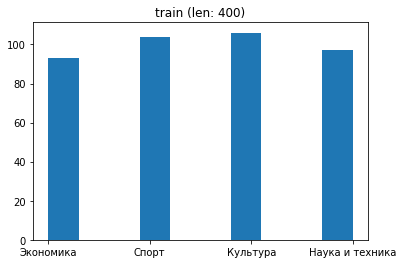

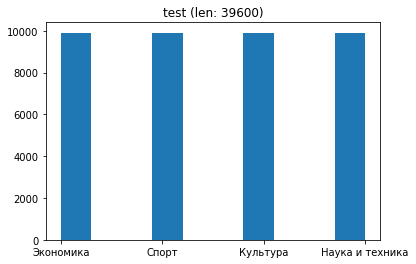

In [110]:
hist_labels(train_gt, topic_labels, "train")
hist_labels(test_gt, topic_labels, "test")

In [111]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [112]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [113]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

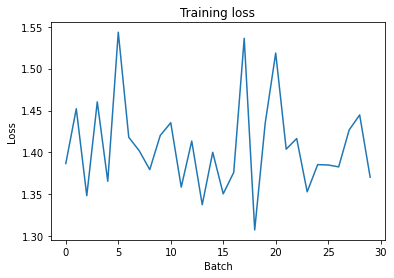

Loss на обучающей выборке: 1.40721


In [114]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

### valid result

In [115]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 22.50%


In [116]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [117]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

### test result

In [118]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 24.98%


In [119]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 29708/39600


In [120]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Культура
  text: в прокат выходит " взрослыи " аргентинскии мультик про марсианина . 19 августа компания " кино без границ " выпускает в россиискии прокат полнометражныи аргентинскии мультфильм " меркано - марсианин " ( mercano , el marciano ) . главныи герои мультфильма летит на землю , чтобы отомстить за свою собачку , погибшую в столкновении с американским космическим кораблем . его " тарелка " терпит крушение в раионе аргентинскои столицы буэнос - аиреса . тоскующии по дому меркано создает виртуальныи марс www . mars . com , которому посвящает весь свои досуг 9 - летнии мальчик хулиан . его отец , возглавляющии огромную корпорацию , узнав о ресурсе , похищает меркано , ч
[positive preds #1]
  class: Культура
  text: в петербурге выставлены на публику любопытные документы из госархивов . в стенах архивного управления санкт - петербурга открылась выставка необычных и редких документов xviii - xix веков из петербургских госархивов . самые любопытные из них

## End